### Build Satellite

In [1]:
from astropy.time import Time
import numpy as np 

""" Satellite orbital parameters """
VE = Time("2024-3-20 3:6:0") # current year's Vernal Equinox
T0 = VE
ecco = 0
argpo = 0 # degrees
inclo = 97.8 # degrees
RAAN = 270 # degrees
period = 100.9 # minutes
mo = 0 # degrees

""" Spacecraft body-frame vectors """
telescope_boresight = np.array([1, 0, 0])
solar_array = np.array([0, 0, -1])
antenna1 = np.array([0, np.sin(np.pi/6), np.cos(np.pi/6)])
antenna2 = np.array([0, np.sin(-np.pi/6), np.cos(-np.pi/6)])
antennas = [antenna1, antenna2]

""" Spacecraft slew data """
# From Paul's sheet, factored in reaction wheel torque and momentum limitations
    # assumed moment of inertia = 2000 kg*m^2 
slew_angle_data = np.array([0, 0.5, 2, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90])
slew_time_data = np.array([30, 30, 66, 102, 138, 168, 198, 240, 276, 306, 336, 366, 414, 468])

In [2]:
from satellite import Satellite
satellite = Satellite.build_from_orbit(T0, ecco, argpo, inclo, RAAN, period, mo)
satellite

/Users/michellekao/Desktop/castor_env/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


<EarthSatellite catalog #0 epoch 2024-03-20 03:06:00 UTC>

### Survey Tiling
Helper functions for tiling, main functions are 'snake_scan_tiling()', 'plot_tiles()', and 'bin_tiles()'. The latter two functions requires the 'tile_centers' returned from 'snake_scan_tiling()'. 

In [3]:
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt

from operations import equi_to_cart, cart_to_equi

""" Tiling functions """

def _rotate(rotation_angle):
    """
    Defines the matrix to rotate a point about the origin (RA=0, DEC=0) counter-clockwise in degrees.
    """
    theta = np.radians(rotation_angle)
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    return Rx

def _move(ra, dec):
    """
    Defines the matrix to move the center point to the desired equitorial coordinates.
    """
    alpha = np.radians(ra)
    delta = np.radians(dec)
    # Move to DEC coordinate
    Ry = np.array([
        [np.cos(delta), 0, -np.sin(delta)],
        [0, 1, 0],
        [np.sin(delta), 0, np.cos(delta)]
    ])
    # Move to RA coordinate
    Rz = np.array([
        [np.cos(alpha), -np.sin(alpha), 0],
        [np.sin(alpha), np.cos(alpha), 0],
        [0, 0, 1]
    ])
    return Rz @ Ry

def _FPA_coords(l, w, g):
    """
    Defines the four corner points of each detector in a 2x2 focal-plane array (FPA), 
    where the array is centered at RA=0, DEC=0.
    Returns a list of 4 sublists, where each sublist corresponds to a detector. Each sublist 
    contains 4 Numpy arrays representing the Cartesian coordinates of the detector's corners, 
    ordered as follows: lower-right, upper-right, upper-left, and lower-left.

    Parameters
    ----------
        l : float
            Detector length in degrees.
        w : float
            Detector width in degrees.
        g : float
            Gap between detectors in degrees.
    Returns
    -------
        list of lists
            Nested list containing Cartesian coordinates for each detector's corners.
    """
    ra_coords = [g/2 + l, g/2 + l, g/2, g/2,
                 g/2 + l, g/2 + l, g/2, g/2,
                 -g/2, -g/2, -(g/2 + l), -(g/2 + l),
                 -g/2, -g/2, -(g/2 + l), -(g/2 + l)]
    
    dec_coords = [-(g/2 + w), -g/2, -g/2, -(g/2 + w),
                  g/2, g/2 + w, g/2 + w, g/2,
                  g/2, g/2 + w, g/2 + w, g/2,
                  -(g/2 + w), -g/2, -g/2, -(g/2 + w)]
    FPA = [[] for _ in range(4)]
    for i in range(16):
        FPA[i // 4].append(equi_to_cart((ra_coords[i], dec_coords[i])))
    return FPA

def create_tile(ra_center, dec_center, rotation_angle, l, w, g, footprint=None):
    """
    Creates a 'tile', which is a MultiPolygon object representing a 2x2 focal-plane array (FPA).
    If the 'footprint' is given, will also returns the 'intersection_ratio' between the 'tile' and the 'footprint'. 

    Parameters
    ----------
        ra_center : float
            Right Ascension of the tile center in degrees.
        dec_center : float
            Declination of the tile center in degrees.
        rotation_angle : float
            Tile rotation angle in degrees (counter-clockwise).
        l : float
            Detector length in degrees.
        w : float
            Detector width in degrees.
        g : float
            Gap between detectors in degrees.
        footprint : shapely.geometry.Polygon
            The survey footprint polygon. Default is None, where 'interesction_ratio' will not be calculated.
    Returns
    -------
        tile : shapely.geometry.MultiPolygon
        intersection_ratio : float
            The ratio indicating how much the tile's area overlaps with the footprint.
            Is returned only if 'footprint' is defined. 
    """
    detectors = []
    intersect_area = 0

    # Define the coordinates of the focal-plane array centered at the origin (RA=0, DEC=0)
    FPA = _FPA_coords(l, w, g)

    # Define the rotation and movement matrices
    rotation_matrix = _rotate(rotation_angle)
    movement_matrix = _move(ra_center, dec_center)
    
    # For each of the detector in the focal-plane array
    for detector in FPA:
        # stores the equitorial vertices of the detector
        RAs = [] 
        DECs = []
        # For the four corners of the detector
        for corner_vec in detector:
            # Rotate the corner about the origin
            rotated_vec = rotation_matrix @ np.array(corner_vec)
            # Move the corner to correct 'RA' and 'DEC'
            moved_vec = movement_matrix @ rotated_vec
            # Convert to equatorial coordinates
            ra, dec = cart_to_equi(moved_vec)
            RAs.append(ra)
            DECs.append(dec)
        # repeat the first vertex to close the polygon
        RAs.append(RAs[0])
        DECs.append(DECs[0])
        # Create a detector Polygon object
        vertices = [(x, y) for x, y in zip(RAs, DECs)]
        polygon = Polygon(vertices)
        if footprint:
            # Find the detector's intersection with the footprint
            detector_with_footprint = polygon.intersection(footprint)
            intersect_area += detector_with_footprint.area
        detectors.append(polygon)
    
    # A 'tile' is a MultiPolygon object consisting of the detector polygons
    tile = MultiPolygon(detectors)
    tile_area = tile.area
    intersection_ratio = intersect_area / tile_area
    if footprint:
        return tile, intersection_ratio
    else:
        return tile

def _rotate2d(x_array, y_array, rotation_angle):
    """
    Performs a 2D rotation (treating as a cartesian plane) on a footprint boundary coordinates set.
    Helper function for snake_scan_tiling().
    """
    x_center = np.mean(x_array)
    y_center = np.mean(y_array)
    x_translated = x_array - x_center
    y_translated = y_array - y_center
    
    # 2D rotation matrix
    theta = np.radians(rotation_angle)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    # Apply rotation
    rotated = rotation_matrix @ np.vstack((x_translated, y_translated))
    x_rotated = rotated[0, :] + x_center
    y_rotated = rotated[1, :] + y_center
    return x_rotated, y_rotated
    
def _rotate_move_grid(ra_grid_flat, dec_grid_flat, rotation_angle, ra_center, dec_center):
    """
    Rotates and moves a grid of tile center coordinates.
    Helper function for snake_scan_tiling().
    """
    new_ra_grid_flat = []
    new_dec_grid_flat = []
    # For each tile center coordinates in the grid
    for RA, DEC in zip(ra_grid_flat, dec_grid_flat):
        # convert to cartesian vector
        vector = equi_to_cart((RA, DEC))
        # rotate about origin
        vector = np.matmul(_rotate(rotation_angle), vector)
        # move to desired RA and DEC
        vector = np.matmul(_move(ra_center, dec_center), vector)
        # convert back to equitorial coordinates
        newRA, newDEC = cart_to_equi(vector)
        new_ra_grid_flat.append(newRA)
        new_dec_grid_flat.append(newDEC)
    return np.array(new_ra_grid_flat), np.array(new_dec_grid_flat)

def snake_scan_tiling(boundary_coords, tile_overlap, l, w, g, rotation_angle=0, min_intersect_ratio=0.5):
    """ 
    Generates a list of tile center coordinates and tile multipolygon objects in the order of 
    the vertical snake scan tiling sequence.

    Parameters
    ----------
        boundary_coords : Numpy array
            An array of footprint boundary coordinates as (ra, dec) in degrees.
            Note: RA values are within [-180, 180°] range.
        tile_overlap : float
            Overlapping length between adjacent tiles in degrees.
        l : float
            Length of each CCD in degrees.
        w : float
            Width of each CCD in degrees.
        g : float
            Gap between CCD arrays in degrees.
        rotation_angle : float
            Tile rotation angle in degrees counter-clockwise (default is 0).
        min_intersect_ratio : float, optional
            Minimum required intersection ratio between a tile and the footprint to be included.
            Must be between 0 and 1 (default is 0.5).
    Returns
    -------
        tile_centers : list of tuples
            List of (RA, DEC) tile center coordinates in degrees ordered in vertical snake scan sequence.
        tile_shapes : list of shapely.geometry.MultiPolygon
            The corresponding MultiPolygon objects for each tile.
    """
    # Define footprint
    footprint = Polygon(boundary_coords)
    if not footprint.is_valid:
        footprint = footprint.buffer(0)
        if not footprint.is_valid:
            raise ValueError("Provided 'boundary_coords' do not form a valid polygon.")

    # Create a cartesian grid boundary
    xmin, ymin, xmax, ymax = footprint.bounds

    # Make the grid boundary bigger considering the projection warp at polar coordinates 
    # (handy-wavy correction)
    if ymin < 30: 
        ymin -= 5
    if ymax > 30:
        ymax += 5

    # Define the corner points of the bounding box
    xbound = np.array([xmin, xmax, xmax, xmin])
    ybound = np.array([ymin, ymin, ymax, ymax])

    # Rotate the boundary
    xbound_rotated, ybound_rotated = _rotate2d(xbound, ybound, rotation_angle)

    # Updated grid boundary (now treated as equatorial coordinates)
    ra_min, ra_max = np.min(xbound_rotated), np.max(xbound_rotated)
    dec_min, dec_max = np.min(ybound_rotated), np.max(ybound_rotated)

    # Avoid computing tiles with RA at the [-180°, 180°] boundary
    ra_min = max(ra_min, -179.9)
    ra_max = min(ra_max, 179.9)

    # Calculate the slew distance (in degrees) between adjacent tiles (not rotated)
    slew_length = (2 * l + g) - tile_overlap
    slew_width = (2 * w + g) - tile_overlap

    # Define a grid of tile centers
    # Let the center of the grid be at origin
    ra_center_grid = (ra_min + ra_max) / 2
    dec_center_grid = (dec_min + dec_max) / 2
    ra_vals = np.arange(ra_min + l, ra_max + l, step=slew_length) - ra_center_grid
    dec_vals = np.arange(dec_min + w, dec_max + w, step=slew_width) - dec_center_grid
    dec_grid, ra_grid = np.meshgrid(dec_vals, ra_vals)

    # Vertical snake tiling: for each RA value, alternate between tiling upwards and downwards
    for i in range(dec_grid.shape[0]):
        if i % 2 == 1:
            dec_grid[i] = dec_grid[i][::-1]

    # The flattened grid contains coordinates in the vertical snake tiling order 
    # still centered at origin
    ra_grid_flat = ra_grid.flatten()
    dec_grid_flat = dec_grid.flatten()
    
    # Apply rotation and move the grid center to the correct coordinates
    ra_list, dec_list = _rotate_move_grid(ra_grid_flat, dec_grid_flat, rotation_angle, ra_center_grid, dec_center_grid)

    # Select tiles that have enough intersection with the footprint
    tile_centers = []
    tile_shapes = []
    for ra, dec in zip(ra_list, dec_list):
        tile, intersection_ratio = create_tile(ra, dec, rotation_angle, l, w, g, footprint)
        if intersection_ratio >= min_intersect_ratio:
            tile_centers.append((ra, dec))
            tile_shapes.append(tile)

    return tile_centers, tile_shapes

In [4]:
def plot_tiles(boundary_coords, tile_centers, tile_shapes, projection_type=None, save_figure=False,
             show_sequence=False, show_tile_centers=False, survey_color='tab:blue'):
    """
    Plots the tiles on the survey footprint.

    Parameters
    ----------
        boundary_coords : Numpy array
            An array of footprint boundary coordinates as (ra, dec) in degrees.
        tile_centers : list of tuples
            List of (ra, dec) tile center coordinates ordered in the tiling sequence.
        tile_shapes : list of shapely.geometry.MultiPolygon
            The corresponding MultiPolygon objects for each tile.
        projection_type : None or 'mollweide'
            If None, uses equirectangular projection.
        save_figure : bool, optional
            If True, saves the plot as 'plot_tiles.pdf'. Otherwise, displays the plot.
        show_sequence : bool, optional
            If True, plots the snake scan tiling sequence.
        show_tile_centers : bool, optional
            If True, plots the centers of the tiles.
        survey_color : str, optional
            Color used to fill the survey tiles.
    Returns
    -------
        None
    """
    # Create plot
    fig = plt.figure(figsize=(9, 9))
    ax = fig.add_subplot(111, projection=projection_type)
    
    # Plot each tile multipolygon
    for tile_object in tile_shapes:
        for geom in tile_object.geoms:
            xs, ys = geom.exterior.xy
            if projection_type == 'mollweide':
                ax.fill(np.radians(np.array(xs)), np.radians(np.array(ys)),
                        alpha=0.5, color=survey_color, ec=None)
            else:
                ax.fill(xs, ys, alpha=0.5, color=survey_color, ec=None)
    
    if projection_type == 'mollweide':
        ax.grid(True)
        # Plot footprint boundary
        ax.plot(np.radians(boundary_coords[:, 0]), np.radians(boundary_coords[:, 1]),
                linewidth=0.8, color='black')
        
        if show_tile_centers or show_sequence:
            ras, decs = zip(*tile_centers)  # Unpack tile centers into separate lists
            if show_tile_centers:
                ax.scatter(np.radians(ras), np.radians(decs), s=5, color='black')
            if show_sequence:
                # Plot snake scan tiling sequence
                ax.plot(np.radians(ras), np.radians(decs), linewidth=0.2, color='tab:red')
    else:
        ax.set_aspect(1)
        # Plot footprint boundary
        ax.plot(boundary_coords[:, 0], boundary_coords[:, 1],
                linewidth=0.8, color='black')
        
        if show_tile_centers or show_sequence:
            ras, decs = zip(*tile_centers)  # Unpack tile centers into separate lists
            if show_tile_centers:
                ax.scatter(ras, decs, s=5, color=survey_color)
            if show_sequence:
                # Plot snake scan tiling sequence
                ax.plot(ras, decs, linewidth=0.6, color='tab:red')
    
    # Set labels and tick parameters
    ax.set_xlabel('R.A. (deg)', fontsize=14)
    ax.set_ylabel('Dec. (deg)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Save or display the figure
    if save_figure:
        plt.savefig('plot_tiles.pdf')
    else:
        plt.show()
    return None


In [5]:
from operations import equi_to_cart, cart_to_equi, hms_to_deg, dms_to_deg
import numpy as np

def make_LSST_DDF(DDF_name):
    """ 
    Create the LSST Deep Drilling Field (DDF) footprint.

    Parameters
    ----------
        DDF_name : str
            Name of the DDF field. Options are 'ELAIS_S1', 'XMM_LSS', 'ECDFS', 'COSMOS'.
    Returns
    -------
        boundary_coords : Numpy array
            Projected footprint outline in equatorial coordinates (RA, DEC).
    """
    
    # Define the DDF footprint shape when centered at RA = 0° and DEC = 0°
    DDF_shape = np.array([[-1.77527778,  1.12916667],
                          [-1.26805556,  1.12916667],
                          [-1.26805556,  1.58083333],
                          [ 1.26805556,  1.58083333],
                          [ 1.26805556,  1.12916667],
                          [ 1.77527778,  1.12916667],
                          [ 1.77527778, -1.12916667],
                          [ 1.26805556, -1.12916667],
                          [ 1.26805556, -1.58083333],
                          [-1.26805556, -1.58083333],
                          [-1.26805556, -1.12916667],
                          [-1.77527778, -1.12916667],
                          [-1.77527778,  1.12916667]])

    # Dictionary to map DDF names to their center coordinates (RA, DEC)
    DDF_centers = {'ELAIS_S1': ((0, 37, 48), (-44, 0, 0)),
                   'XMM_LSS': ((2, 22, 50), (-4, 45, 0)),
                   'ECDFS': ((3, 32, 30), (-28, 6, 0)),
                   'COSMOS': ((10, 0, 24), (2, 10, 55))}

    # Get the center coordinates (in degrees) for the given DDF name
    RA_hms, DEC_dms = DDF_centers.get(DDF_name, ((0, 0, 0), (0, 0, 0)))
    RA, DEC = hms_to_deg(*RA_hms), dms_to_deg(*DEC_dms)

    # Project the DDF footprint shape to the desired coordinates to get the correct footprint outline
    proj_footprint = [cart_to_equi(np.matmul(_move(RA, DEC), equi_to_cart(vertex))) for vertex in DDF_shape]
    boundary_coords = np.array(proj_footprint)
    return boundary_coords


In [6]:
""" Tile parameters """
# Each tile, or field of view, is a 2x2 CCD array
tile_overlap = 30/3600 # adjacent tiles overlapping length in degrees
l = 900/3600 # each CCD length in degrees
w = 860/3600 # each CCD width in degrees
g = 26/3600 # gap between CCD arrays in degrees

In [42]:
# Define footprint boundary
DDF_name = 'XMM_LSS'
boundary_coords = make_LSST_DDF(DDF_name)

rotation_angle = 0
tile_centers, tile_shapes = snake_scan_tiling(boundary_coords, tile_overlap, l, w, g, 
                                              rotation_angle, min_intersect_ratio=0.3)
total_tiles = len(tile_centers)
print(f'LSST Deep Drilling Field: {DDF_name} contains {total_tiles} tiles.')

LSST Deep Drilling Field: XMM_LSS contains 45 tiles.


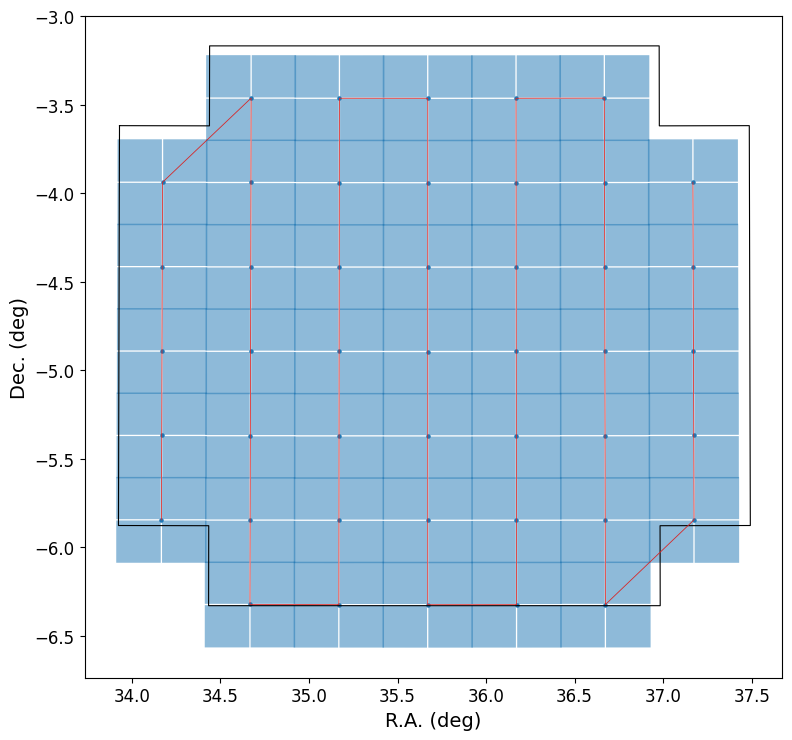

In [43]:
plot_tiles(boundary_coords, tile_centers, tile_shapes, projection_type=None, save_figure=False,
             show_sequence=True, show_tile_centers=True, survey_color='tab:blue')

### Slews

In [9]:
import numpy as np

from targets import InertialTarget, SolarSystemTarget, EarthOrbitingTarget, EarthFixedTarget
from operations import _ECI_to_body

def large_slew(initial_time, final_time, initial_target, final_target, telescope_boresight, solar_array, satellite):
    """
    Calculates the slew angle in degrees from 'initial_target' to 'final_target' by finding the difference 
    between the initial and final pointing quaternion, which aligns the 'telescope_boresight' to the target 
    and aligns the 'solar_array' towards the Sun as close as possible. 

    Parameters
    ----------
        initial_time, final_time : Astropy Time objects
            The time for defining the initial and final pointing direction. 
        initial_target, final_target : Target objects
            Must be instances of InertialTarget, SolarSystemTarget, or EarthOrbitingTarget.
        telescope_boresight, solar_array : Numpy array
            Spacecraft body-frame unit vectors.
        satellite : skyfield.sgp4lib.EarthSatellite
    Returns
    -------
        slew_angle : float
    """
    # Check if targets are of correct type
    if not isinstance(initial_target, (InertialTarget, SolarSystemTarget, EarthOrbitingTarget)):
        raise TypeError("'initial_target' must be an instance of InertialTarget, SolarSystemTarget, or EarthOrbitingTarget.")
    if not isinstance(final_target, (InertialTarget, SolarSystemTarget, EarthOrbitingTarget)):
        raise TypeError("'final_target' must be an instance of InertialTarget, SolarSystemTarget, or EarthOrbitingTarget.")

    # Define pointings in ECI frame
    initial_target_pointing = initial_target.pointing(satellite, initial_time)
    initial_sun_pointing = SolarSystemTarget('sun').pointing(satellite, initial_time)
    final_target_pointing = final_target.pointing(satellite, final_time)
    final_sun_pointing = SolarSystemTarget('sun').pointing(satellite, final_time)
    
    # q0: initial pointing quaternion
    q0 = _ECI_to_body(initial_target_pointing, telescope_boresight, initial_sun_pointing, solar_array)
    # qf: final pointing quaternion
    qf = _ECI_to_body(final_target_pointing, telescope_boresight, final_sun_pointing, solar_array)
    # qe: error quaternion, i.e. the difference between the two pointing quaternions
    qe = q0.inverse*qf
    
    slew_angle = abs(qe.degrees)
    return slew_angle

def _tile_orientation(coord, rotation_angle, telescope_boresight):
    """
    Defines the telescope pointing quaternion (i.e. spacecraft roll) to match 
    with the given tile's orientation (i.e. 'rotation_angle'). 
    Helper function for inter_tile_slew().
    
    Parameters
    ----------
        coord : tuple 
            Tile center coordinates (RA, DEC) in degrees.
        rotation_angle: float
            Tile rotation angle in degrees counter-clockwise.
    Returns
    -------
        q : Quaternion object
    """
    # Optical Axis unit vector: points toward the tile's center coordinate
    u_oa = equi_to_cart(coord)
    
    # North Celestial Pole unit vector: points towards the NCP but perpendicular to the Optical Axis.
    # define the actual north celestial pole vector
    NCP = [0,0,1] 
    # define the rotation axis unit vector
    k = np.cross(u_oa, NCP) / np.linalg.norm(np.cross(u_oa, NCP))
    # rotate u_oa by 90° around axis k (see Rodrigues' rotation formula)
    u_ncp = np.cross(k, u_oa)

    # Tile Rotation unit vector
    # Defined by rotating the NCP Vector about the Optical Axis Vector by the rotation_angle
    # (see Rodrigues' rotation formula)
    u_tr = u_ncp*np.cos(rotation_angle) + np.cross(u_oa, u_ncp)*np.sin(rotation_angle) + u_oa*np.dot(u_oa, u_ncp)*(1-np.cos(rotation_angle))

    # Pointing quaternion
    # Defined by rotating the telescope boresight to Optical Axis Vector (primary) 
    # and +Z body to Tile Rotation Vector (secondary)
    # Note: assume +Z body is in the same direction as pointing from center to the top of the tile
    q = _ECI_to_body(u_oa, telescope_boresight, u_tr, np.array([0,0,1]))
    return q

def inter_tile_slew(tile1, tile2, rotation_angle, telescope_boresight):
    """
    Calculates the slew angle from 'tile1' to 'tile2'.
    
    Parameters
    ----------
        tile1, tile2 : InertialTarget objects
        rotation_angle : float
            Tile rotation angle in degrees counter-clockwise.
    Returns
    -------
        slew_angle : float
    """
    if not isinstance(tile1, InertialTarget):
        raise TypeError("'tile1' must be an instance of InertialTarget.")
    if not isinstance(tile2, InertialTarget):
        raise TypeError("'tile2' must be an instance of InertialTarget.")
    
    # q1: tile 1 pointing quaternion
    q1 = _tile_orientation((tile1.ra, tile1.dec), rotation_angle, telescope_boresight)
    # q2: tile 2 pointing quaternion
    q2 = _tile_orientation((tile2.ra, tile2.dec), rotation_angle, telescope_boresight)
    # qe: error quaternion, i.e. the difference between the two pointing quaternions
    qe = q1.inverse*q2
    
    slew_angle = abs(qe.degrees)
    return slew_angle

def slew_angle_to_time(slew_angle, slew_angle_data, slew_time_data):
    """
    Estimate the slew time in seconds associated to the 'slew_angle' by interpolating the slew_angle_data vs. slew_time_data.

    Parameters
    ----------
        slew_angle : float
        slew_angle_data, slew_time_data : list of floats
            Look-up table of slew angle (in degrees) vs. slew time (in seconds) data.
    Returns
    -------
        slew_time : float
    """
    slew_time = np.interp(slew_angle, slew_angle_data, slew_time_data)
    if abs(slew_angle) > 90:
        # for slews greater than 90 deg, set slew time = 8 minutes
        slew_time = 480
    return slew_time

### Observation

In [47]:
import numpy as np
import astropy.units as u
from astropy.time import Time
from skyfield.api import load

""" Functions for Observation """
def _find_CVZcenter(satellite, time):
    """
    Find the equitorial coordinates (ra, dec) corresponding to the continuous viewing zone (CVZ) center 
    of the satellite at the given time.

    Parameters
    ----------
        satellite : skyfield.sgp4lib.EarthSatellite
        time : Astropy Time object
    Returns
    -------
        CVZ_ra, CVZ_dec : tuple
    """
    # Define the Right Ascension of the CVZ center
    # as the RA of anti Sun direction
    t = load.timescale().from_astropy(time)
    CVZ_ra, _ = cart_to_equi(-SolarSystemTarget('sun').pointing(satellite, time))
    # Define the Declination of the CVZ center
    inclo = np.degrees(satellite.model.inclo) # orbital inclination
    CVZ_dec = 90 - inclo
    return CVZ_ra, CVZ_dec

def _find_anti_SunRA_day(surveyRA, VE):
    """
    Finds the day when the Solar longitude (the Sun's RA position) is positioned 180° away 
    along the ecliptic from 'surveyRA' on the celestial sphere.
    i.e., the day when the survey is in the opposite direction from the Sun as seen from Earth. 
    
    Parameters
    ----------
        surveyRA : float
            Right Ascension value in [-180°, +180°] range. 
        VE : Astropy Time object
                Vernal Equinox of the current year in UTC.
                e.g., VE = Time("2024-3-20 3:6:0") for March 20, 2024 at 03:06 UTC 
    Returns
    -------
        anti_SunRA_day : Astropy Time object
    """
    # lamda: Sun ecliptic longitude; lamda = 0° on Vernal Equinox
    # anti_lamda: opposite of Sun ecliptic longitude starting on Vernal Equinox
    anti_lamda = np.arange(-180, 180, step=360/365.25)
    anti_SunRA_data = []
    for i in anti_lamda:
        anti_SunRA_data.append(i + 2.45 * np.sin(np.radians(2*i)))
    delta_day_data = np.arange(len(anti_SunRA_data))
    delta_day = np.interp(surveyRA, anti_SunRA_data, delta_day_data)
    anti_SunRA_datetime = VE + delta_day*u.day
    anti_SunRA_day = Time(anti_SunRA_datetime.iso.split()[0])
    return anti_SunRA_day
    
def find_occultation(tile, Now, duration, subexposure, period, satellite):
    """ 
    Determines whether occultation occurs by checking if the 'tile' is visible throughout the 'subexposure' time,
    which starts 'duration' after 'Now'. If there is occultation, it defines the visibility windows over an orbital 
    period, and saves it as a 'tile' attribute. Then calculates the occulted time from 'Now' to the start of the 
    tile's new visible cycle.

    Parameters
    ----------
        tile : InertialTarget object
        Now : Astropy Time object
            The current time of observation.
        duration : float
            The time in seconds from 'Now' before the planned imaging start time.
        subexposure : float
            The continuous open-shutter time in seconds.
        period : float
            Satellite's orbital period in minutes. 
    Returns
    -------
        occultation : float
            The time in seconds when the 'tile' is not visible (e.g. occulted by the Earth's limb).
    """
    import timeit
    code_start = timeit.default_timer()
    
    if (tile.avoid_bright_objects(satellite, Now+duration*u.s) is True) and (tile.avoid_bright_objects(satellite, Now+duration*u.s+subexposure*u.s) is True):
        # If the tile is visible throughout the open-shutter time,
        # there is no occultation
        occultation = 0
        # print(f'occultation = {round(occultation/60, 2)} min')
    else:
        # Scan for the tile's visibility window per minute over an orbital period
        tile.orbit_vis = tile.get_visibility_windows(Now, Now+period*u.min, 60, satellite)
        if tile.orbit_vis.num == 0:
            raise ValueError("The target currently has no visibility window.")
        # Calculate occultation, i.e. the time from 'Now' to the start of new visible cycle.
        occultation = (tile.orbit_vis.get_start_time() - Now).sec
        # print(f'occultation = {round(occultation/60, 2)} min')
        runtime = timeit.default_timer() - code_start
        # print(f"runtime: {runtime} sec")
    if occultation < 0:
        raise ValueError("Occultation time cannot be negative!")
    return occultation

def get_view_eff(tile, Now, period):
    """ 
    Defines the visibility windows over an orbital period, and saves it as a 'tile' attribute.
    Calculates the viewing efficiency, which is the fraction of the orbit where the 'tile' is 
    not occulted by the Earth. 
    """
    if tile.orbit_vis is None:
        # Scan for the tile's visibility window per minute over an orbital period
        tile.orbit_vis = tile.get_visibility_windows(Now, Now+period*u.min, 60, satellite)
    # Find the total viewing time over an orbit in seconds
    view_time = tile.orbit_vis.get_timespan()
    view_eff = view_time / (period*60)
    return view_eff

# Print seconds in day, hr, min, sec format
def print_time(seconds):
    days = seconds // (24 * 3600)
    seconds %= (24 * 3600)
    hours = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    # only show non-zero values to keep it clean
    time_str = []
    if days > 0:
        time_str.append(f"{int(days)} day{'s' if days > 1 else ''}")
    if hours > 0 or days > 0:
        time_str.append(f"{int(hours):02} hr")
    if minutes > 0 or hours > 0 or days > 0:
        time_str.append(f"{int(minutes):02} min")
    time_str.append(f"{seconds} sec")
    return ', '.join(time_str)

In [11]:
from shapely.geometry import Polygon

""" Functions for Small Surveys """
def _footprint_is_visible(candidate_day, vertex_targets, satellite):
    """
    Checks the visibility of the footprint. 
    Returns 'True' if the footprint is visible on the 'candidate day', 'False' otherwise.
    """
    coarse_start_time = candidate_day
    for vertex in vertex_targets:
        # Check if the footprint is visible throughout the day
        # Coarse calculation: step through half a day per 30 minutes
        coarse_vis = vertex.get_visibility_windows(candidate_day, candidate_day+12*u.hour, 1800, satellite)
        if coarse_vis.num == 0:
            return False
    return True

def find_daily_start_time(day_num, boundary_coords, tile_targets, period, VE, satellite, specific_day=None):
    """
    Determines the optimal start time for observing the small survey on each the day(s) the survey is visible. 
    For daily cadence surveys, 'day_num' specifies the number of required observation days. 
    If 'day_num' is 1, the 'specific_day' parameter allows the user to specify the exact day of interest. 

    Parameters
    ----------
        day_num : int
            The number of days for which the user wants to determine the observing efficiency of the small survey.
        boundary_coords : Numpy array
            An array of footprint boundary coordinates (RA, DEC) in degrees.
        tile_targets : list of Target objects
            A list of target objects converted from 'tile_centers'.
        period : float
            The satellite's orbital period in minutes.
        VE : Astropy Time object
            Vernal Equinox of the current year in UTC.
            e.g., VE = Time("2024-3-20 3:6:0") for March 20, 2024 at 03:06 UTC   
        specific_day : Astropy Time object, optional
            If 'day_num' is 1, this parameter allows the user to specify the day to view the survey's observing efficiency.
            If left as None, it picks 'anti_SunRA_day' as default.  
    Returns
    -------
        start_times : list of Astropy Time objects
    """
    # Convert 'boundary_coords' to a list of Target objects representing the survey's rectangular bounds
    minRA, minDEC, maxRA, maxDEC = Polygon(boundary_coords).bounds
    vertex_targets = [InertialTarget(RA, DEC) for RA in [minRA, maxRA] for DEC in [minDEC, maxDEC]]
    # Define the RA of the survey center
    surveyRA = (minRA + maxRA)/2
    
    # Find the day when the survey is in the anti-Sun direction seen from Earth
    anti_SunRA_day = _find_anti_SunRA_day(surveyRA, VE)
    
    # Set the starting day
    if day_num==1 and specific_day:
        start_day = specific_day
    else:
        # Note: for cadence surveys requiring daily observations over months, 
        # start the visible day search from 'anti_SunRA_day'
        start_day = anti_SunRA_day

    # To search for all the visible days, start from the two ends centered on 'anti_SunRA_day'.
    buffer = 2 # add two extra days on both ends
    first_day = start_day - int(day_num/2 + buffer)*u.day
    last_day = start_day + int(day_num/2 + buffer)*u.day
    # Move forward/backward in time until the footprint is visible on 'first_day'/'last_day'
    while not _footprint_is_visible(first_day, vertex_targets, satellite):
        first_day += 1*u.day
    while not _footprint_is_visible(last_day, vertex_targets, satellite):
        last_day -= 1*u.day
    # Create the list of visible days
    day_range = np.arange(0, int((last_day - first_day).value)+1, 1)
    day_array = first_day + day_range*u.day

    # Find the start_time of each day
    start_times = []
    for i, day in enumerate(day_array):
        coarse_start_time = day
        # Fine calculation: step through an orbital period per two minutes
        vis = tile_targets[0].get_visibility_windows(coarse_start_time, coarse_start_time+period*u.min, 2*60, satellite)
        if vis.num != 0:
            # Define the start time to be the beginning of a new visibility cycle
            start_time = vis.get_start_time()
            print(start_time)
            start_times.append(start_time)
    return start_times

In [12]:
""" Telescope parameters """
# Dither
subexposure_num = 4

# Times are all in seconds
readout = 0.02 # read out time per subexposure
settle = 90 # settle time + FGS(Fine Guidance Sensors) scan ID time
GSacquire = 30 # guide star aquisition time
dither = 30 # an estimate of total (primary + subpx) dither time per tile

# Data
px_amount = 8600 * 9000 * 4 * 3 # number of pixels per subexposure
byte_per_px = 2 # bytes per pixel
# amount of data (in GB) obtained per subexposure readout
data = (px_amount * byte_per_px)/10**9 # in GB
# data generated internally due to performance
internal_data_rate = 0.0001/8 # in GBps

#### Small Survey Observation

In [13]:
""" Small survey parameters """
exposure = 100 # exposure time per tile 
subexposure = exposure / subexposure_num # time per subexposures
# the number of days for which the user wants to determine the observing efficiency of the survey
day_num = 180
# Define the other survey's required minimum continuous observation time in seconds
min_other_obs_time = 60

In [14]:
from targets import InertialTarget, SolarSystemTarget, EarthOrbitingTarget, EarthFixedTarget
# Convert the list of tile center coordinates to a list of tile target objects 
tile_targets = [InertialTarget(RA, DEC) for RA, DEC in tile_centers]

""" 
Determine the days when the small survey field is visible (i.e. the boresight is not pointing too close to the Sun).
"""
import timeit
code_start = timeit.default_timer()
# the number of days for which the user wants to determine the observing efficiency of the survey
day_num = 180
start_times = find_daily_start_time(day_num, boundary_coords, tile_targets, period, VE, satellite)
runtime = timeit.default_timer() - code_start
print(f"runtime: {runtime/60} min.")

The target is occulted by sun, earth.
The target is occulted by sun, earth.
The target is occulted by sun, earth.
The target is occulted by sun, earth.
The target is occulted by sun, earth.
The target is occulted by sun, earth.
The target is occulted by sun, earth.
The target is occulted by sun, earth.
2024-07-27 00:58:00.000
2024-07-28 00:32:00.000
2024-07-29 00:04:00.000
2024-07-30 01:20:00.000
2024-07-31 00:52:00.000
2024-08-01 00:26:00.000
2024-08-02 01:40:00.000
2024-08-03 01:14:00.000
2024-08-04 00:48:00.000
2024-08-05 00:22:00.000
2024-08-06 01:36:00.000
2024-08-07 01:08:00.000
2024-08-08 00:42:00.000
2024-08-09 00:16:00.000
2024-08-10 01:30:00.000
2024-08-11 01:04:00.000
2024-08-12 00:38:00.000
2024-08-13 00:10:00.000
2024-08-14 01:24:00.000
2024-08-15 00:58:00.000
2024-08-16 00:32:00.000
2024-08-17 00:06:00.000
2024-08-18 01:20:00.000
2024-08-19 00:54:00.000
2024-08-20 00:26:00.000
2024-08-21 01:40:00.000
2024-08-22 01:14:00.000
2024-08-23 00:48:00.000
2024-08-24 00:22:00.000


In [45]:
# Least and most efficient observation days
least_efficient_day = start_times[0]
most_efficient_day = start_times[100]

### Exposure time vs. Observing efficiency Analysis

In [63]:
import copy

""" Exposure time vs. Observing Efficiency & Exposure time vs. Total time elapsed """
step_size = 10
exposure_vals = np.arange(100, 1200+step_size, step_size)

# Define the other survey's minimum continuous observation time (in seconds) required
min_other_obs_time = 60

import timeit
total_code_start = timeit.default_timer()
""" TEST on the least and most efficient observation days """
# Define the observation day (i.e. 'start_time')
for start_time in [least_efficient_day, most_efficient_day]:
    print('start_time:', start_time)
    obs_effs = []
    total_times = []
    survey_times = []
    
    for exposure in exposure_vals:
        subexposure = exposure / subexposure_num # time per subexposures
        
        Now = start_time
        """ Tracker """
        Slew = 0
        Settle = 0
        GS_Acquisition = 0
        Exposure = 0
        Dither = 0
        Readout = 0
        Data_Onboard = 0
            
        # Stores the total time segments in seconds allocated to observing other surveys 
        # (including the time to slew, settle, and acquire a new guide star)
        other_survey_segments = []
        # Stores the deadtime segments in seconds
        deadtime_segments = []
        # Stores tiles in the observation sequence 
        observation_sequence = []
        # Tracks when the last time data generated internally is accounted for 
        prev_internal_data_check = start_time
        
        """ less important """
        # stores the other survey observation time segments in seconds
        other_survey_obs_time = [] 
        # tracks the number of tiles imaged or in the process of imaging
        # (currently only use for identifying initial slew and
        # used for printing sanity checks to identify which tile is currently being observed)
        tile_num = 0 # stored as tile.index 
        
        """ track code runtime """
        import timeit
        code_start = timeit.default_timer()
        
        # Create a copy of the tile targets
        tiles = copy.deepcopy(tile_targets)
        
        while tiles:
            # print(f'\033[1mTime Elapsed: {print_time((Now - start_time).sec)}\033[0m')
            
            # Select the tile in snake-scan order
            tile = tiles.pop(0)
            
            # Define slew
            if tile_num == 0:
                # Initial observation
                # Assume the satellite slews from its CVZ (continuous viewing zone) center
                CVZ = InertialTarget(*_find_CVZcenter(satellite, Now))
                slew_angle = large_slew(Now, Now, CVZ, tile, telescope_boresight, solar_array, satellite)
                slew = slew_angle_to_time(slew_angle, slew_angle_data, slew_time_data)
            else:
                # Subsequent observations
                slew_angle = inter_tile_slew(prev_tile, tile, rotation_angle, telescope_boresight)
                slew = slew_angle_to_time(slew_angle, slew_angle_data, slew_time_data)
        
            # Assign an index to the tile for future reference
            if tile.index is None:
                tile_num += 1
                tile.index = tile_num
                
            # Calculate the tile's occultation if its undefined or outdated
            if (tile.orbit_vis is None) or (tile.orbit_vis and tile.orbit_vis.get_start_time() < Now):
                tile.occultation = find_occultation(tile, Now, slew+settle+GSacquire, subexposure, period, satellite)
        
            # Check for the selected tile's occultation and determine its status
            # If the tile is currently occulted
            if tile.occultation > 0:
                # Find the slew time to other surveys located at the CVZ center 
                slew_angle = large_slew(Now, Now, prev_tile, CVZ, telescope_boresight, solar_array, satellite)
                slew_to_CVZ = slew_angle_to_time(slew_angle, slew_angle_data, slew_time_data)
                # Find the observation time available for the other survey
                other_obs_time = tile.occultation - (slew_to_CVZ + settle + GSacquire)*2
                # Note: assumed the slew back time is the same as 'slew_to_CVZ'
                if other_obs_time > min_other_obs_time:
                    tile.status = "other"
                    # If the occultation time is long enough to allow slewing to and back from the other survey, 
                    # then allocate the slew to and the obervation time to the other survey 
                    other_survey_obs_time.append(other_obs_time)
                    other_survey = slew_to_CVZ + settle + GSacquire + other_obs_time
                    other_survey_segments.append(other_survey)
                    # print('Other survey time:', print_time(other_survey))
                    # Update 'Now' to be after observing other surveys
                    Now += other_survey*u.s
                    # print(f'\033[1mTime Elapsed: {print_time((Now - start_time).sec)}\033[0m') 
                    # Define the slew back from other surveys
                    slew = slew_to_CVZ
                    # print('slew back from other surveys')
                else:
                    tile.status = "dead"
                    # Or else count the occultation time as deadtime (and not slew to other surveys)
                    deadtime = tile.occultation
                    # Note: start slewing to the target (if applicable) during its occultation
                    if slew != 0:
                        deadtime -= slew + settle + GSacquire
                    deadtime_segments.append(deadtime)
                    # print('Add deadtime:', print_time(deadtime))
                    # Update 'Now' to be after deadtime
                    Now += deadtime*u.s
                    # print(f'\033[1mTime Elapsed: {print_time((Now - start_time).sec)}\033[0m') 
            else:
                tile.status = "visible"
        
            # Account for slew, settle, and GS aquisition (if applicable)
            if slew != 0:
                Slew += slew
                Settle += settle
                GS_Acquisition += GSacquire
                # Update time
                Now += slew*u.s + settle*u.s + GSacquire*u.s
            
                # print('slew:', print_time(slew))
                # print(f'\033[1mtile {tile.index}\033[0m')
                # print('settle + GS acquisition:', print_time(settle+GSacquire))
                # print(f'\033[1mTime Elapsed: {print_time((Now - start_time).sec)}\033[0m')
                
            # Exposure and data readout
            while tile.subexposure_count < subexposure_num:
                # Check for occultation
                tile.occultation = find_occultation(tile, Now, 0, subexposure, period, satellite) 
                # When occultation occurs, stop imaging to reselect the tile
                if tile.occultation > 0:
                    tiles.insert(0, tile)
                    break   
                # Imaging
                Exposure += subexposure
                Dither += dither/subexposure_num
                Readout += readout
                # Account for data degenerated from image readout
                Data_Onboard += data 
                # Update time
                Now += (subexposure + dither/subexposure_num + readout)*u.s
                # print('imaging + dither per subexposure:', subexposure + dither/subexposure_num + readout, 's')
                tile.subexposure_count += 1
            
            # Document the previous tile
            prev_tile = tile
            # Document the observation sequence
            # append a copy of the 'tile' so any status changes later on won't affect the copy in the list
            observation_sequence.append(copy.deepcopy(tile)) 
        
            # Account for the data generated internally
            Data_Onboard += (Now - prev_internal_data_check).sec * internal_data_rate
            prev_internal_data_check = Now
            # print('data onboard:', Data_Onboard, 'GB')
        
        Total_Time = (Now - start_time).sec
        Other_Survey = sum(other_survey_segments)
        This_Survey = Total_Time - Other_Survey
        Deadtime = sum(deadtime_segments)
        obs_efficiency = (Exposure/This_Survey)*100
        
        # print(f'Observation day: {start_time}')
        print(f'\033[1mExposure per tile: {exposure} sec\033[0m')
        print('Total time elapsed:', print_time(Total_Time))
        # print('Time spent on this survey:', print_time(This_Survey))
        # print('Time spent on other surveys:', print_time(Other_Survey))
        # print(f'i.e. {(Other_Survey/Total_Time)*100} % of the total time elapsed')
        # print('Deadtime:', print_time(Deadtime))
        print(f'Observing Efficiency: {obs_efficiency} %')
        # print(f'Total slew time: {print_time(Slew)}')
        # print(f'i.e. {(Slew/This_Survey)*100} % of the time spent on this survey')
        # print('data acquired:', Data_Onboard, 'GB')
        
        runtime = timeit.default_timer() - code_start
        print('code runtime:', print_time(runtime))
        print()

        obs_effs.append(obs_efficiency)
        total_times.append(Total_Time)
        survey_times.append(This_Survey)

    if start_time == least_efficient_day:
        obs_eff_least = obs_effs
        total_time_least = total_times
        survey_time_least = survey_times
    else:
        obs_eff_most = obs_effs
        total_time_most = total_times
        survey_time_most = survey_times
total_runtime = timeit.default_timer() - total_code_start
print('total code runtime', print_time(total_runtime))

start_time: 2024-07-27 00:58:00.000
Exposure per tile: 100 sec
Total time elapsed: 05 hr, 37 min, 12.85874569745647 sec
Observing Efficiency: 31.222119632188484 %
code runtime: 28.61476970789954 sec

Exposure per tile: 110 sec
Total time elapsed: 05 hr, 46 min, 42.85874569766747 sec
Observing Efficiency: 32.645559013761314 %
code runtime: 15.74373283283785 sec

Exposure per tile: 120 sec
Total time elapsed: 05 hr, 54 min, 42.858745697987615 sec
Observing Efficiency: 34.9223910585251 %
code runtime: 13.838115249760449 sec

Exposure per tile: 130 sec
Total time elapsed: 05 hr, 56 min, 42.85874569686348 sec
Observing Efficiency: 37.11255740077608 %
code runtime: 13.826579417102039 sec

Exposure per tile: 140 sec
Total time elapsed: 06 hr, 51 min, 12.858745697179984 sec
Observing Efficiency: 36.81442179603136 %
code runtime: 17.99168520886451 sec

Exposure per tile: 150 sec
Total time elapsed: 06 hr, 57 min, 12.858745697471022 sec
Observing Efficiency: 39.44402335289006 %
code runtime: 19.

In [114]:
total_time_most_hr = np.array(total_time_most)/3600
total_time_least_hr = np.array(total_time_least)/3600
idx = np.argmax(total_time_least_hr > 24)

In [117]:
exposure_vals[:idx]

array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900, 910, 920, 930])

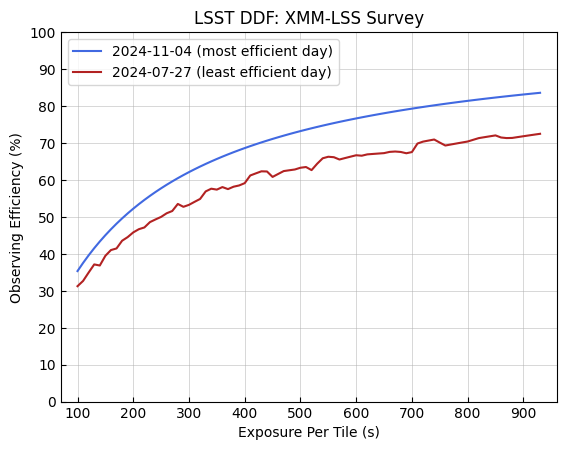

In [145]:
import matplotlib as mpl
import matplotlib.pyplot as plt

style_path = "MNRAS.mplstyle"
plt.style.use('default')
# plt.style.use(style_path)

fig = plt.figure()
plt.plot(exposure_vals[:idx], obs_eff_most[:idx], label=f"{most_efficient_day.strftime('%Y-%m-%d')} (most efficient day)", color='royalblue')
plt.plot(exposure_vals[:idx], obs_eff_least[:idx], label=f"{least_efficient_day.strftime('%Y-%m-%d')} (least efficient day)", color='firebrick')

plt.xlim(70, 960)
plt.ylim(0, 100)
plt.xticks(range(100, 1000, 100))
plt.yticks(range(0, 110, 10))
plt.tick_params(direction='in')

plt.xlabel('Exposure Per Tile (s)')
plt.ylabel('Observing Efficiency (%)')
plt.title('LSST DDF: XMM-LSS Survey')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.7, linewidth=0.5)
plt.savefig('obs_eff vs. exposure.pdf')
plt.show()


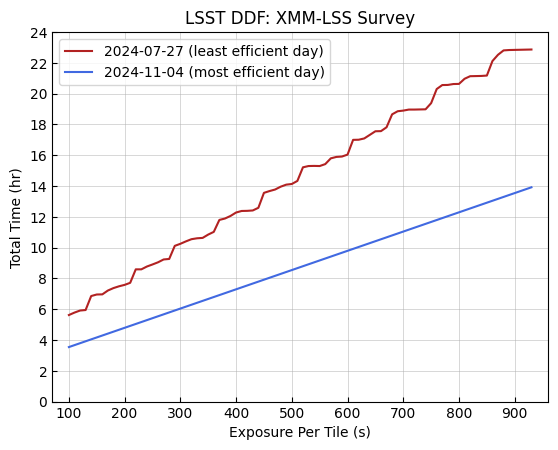

In [143]:
fig = plt.figure()
plt.style.use('default')
plt.plot(exposure_vals[:idx], total_time_least_hr[:idx], label=f"{least_efficient_day.strftime('%Y-%m-%d')} (least efficient day)", color='firebrick')
plt.plot(exposure_vals[:idx], total_time_most_hr[:idx], label=f"{most_efficient_day.strftime('%Y-%m-%d')} (most efficient day)", color='royalblue')
plt.xlim(70, 960)
plt.ylim(0, 24)
plt.xticks(range(100, 1000, 100))
plt.yticks(range(0, 25, 2))
plt.tick_params(direction='in')
plt.xlabel('Exposure Per Tile (s)')
plt.ylabel('Total Time (hr)')
plt.title('LSST DDF: XMM-LSS Survey')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.7, linewidth=0.5)
plt.savefig('total_time vs. exposure.pdf')
plt.show()

In [30]:
import copy
""" Small Survey Parameters """
exposure = 100 # exposure time per tile 
subexposure = exposure / subexposure_num # time per subexposures
# Define the other survey's minimum continuous observation time (in seconds) required
min_other_obs_time = 60

# Define the observation day (i.e. 'start_time')
""" TEST with different observation days """
start_time = most_optimal_day
Now = start_time
# print('start_time:', Now)

""" Tracker """
Slew = 0
Settle = 0
GS_Acquisition = 0
Exposure = 0
Dither = 0
Readout = 0
Data_Onboard = 0
    
# Stores the total time segments in seconds allocated to observing other surveys 
# (including the time to slew, settle, and acquire a new guide star)
other_survey_segments = []
# Stores the deadtime segments in seconds
deadtime_segments = []
# Stores tiles in the observation sequence 
observation_sequence = []
# Tracks when the last time data generated internally is accounted for 
prev_internal_data_check = start_time

""" less important """
# stores the other survey observation time segments in seconds
other_survey_obs_time = [] 
# tracks the number of tiles imaged or in the process of imaging
# (currently only use for identifying initial slew and
# used for printing sanity checks to identify which tile is currently being observed)
tile_num = 0 # stored as tile.index 

""" track code runtime """
import timeit
code_start = timeit.default_timer()

# Create a copy of the tile targets
tiles = copy.deepcopy(tile_targets)

while tiles:
    # print(f'\033[1mTime Elapsed: {print_time((Now - start_time).sec)}\033[0m')
    
    # Select the tile in snake-scan order
    tile = tiles.pop(0)
    
    # Define slew
    if tile_num == 0:
        # Initial observation
        # Assume the satellite slews from its CVZ (continuous viewing zone) center
        CVZ = InertialTarget(*_find_CVZcenter(satellite, Now))
        slew_angle = large_slew(Now, Now, CVZ, tile, telescope_boresight, solar_array, satellite)
        slew = slew_angle_to_time(slew_angle, slew_angle_data, slew_time_data)
    else:
        # Subsequent observations
        slew_angle = inter_tile_slew(prev_tile, tile, rotation_angle, telescope_boresight)
        slew = slew_angle_to_time(slew_angle, slew_angle_data, slew_time_data)

    # Assign an index to the tile for future reference
    if tile.index is None:
        tile_num += 1
        tile.index = tile_num
        
    # Calculate the tile's occultation if its undefined or outdated
    if (tile.orbit_vis is None) or (tile.orbit_vis and tile.orbit_vis.get_start_time() < Now):
        tile.occultation = find_occultation(tile, Now, slew+settle+GSacquire, subexposure, period, satellite)

    # Check for the selected tile's occultation and determine its status
    # If the tile is currently occulted
    if tile.occultation > 0:
        # Find the slew time to other surveys located at the CVZ center 
        slew_angle = large_slew(Now, Now, prev_tile, CVZ, telescope_boresight, solar_array, satellite)
        slew_to_CVZ = slew_angle_to_time(slew_angle, slew_angle_data, slew_time_data)
        # Find the observation time available for the other survey
        other_obs_time = tile.occultation - (slew_to_CVZ + settle + GSacquire)*2
        # Note: assumed the slew back time is the same as 'slew_to_CVZ'
        if other_obs_time > min_other_obs_time:
            tile.status = "other"
            # If the occultation time is long enough to allow slewing to and back from the other survey, 
            # then allocate the slew to and the obervation time to the other survey 
            other_survey_obs_time.append(other_obs_time)
            other_survey = slew_to_CVZ + settle + GSacquire + other_obs_time
            other_survey_segments.append(other_survey)
            # print('Other survey time:', print_time(other_survey))
            # Update 'Now' to be after observing other surveys
            Now += other_survey*u.s
            # print(f'\033[1mTime Elapsed: {print_time((Now - start_time).sec)}\033[0m') 
            # Define the slew back from other surveys
            slew = slew_to_CVZ
            # print('slew back from other surveys')
        else:
            tile.status = "dead"
            # Or else count the occultation time as deadtime (and not slew to other surveys)
            deadtime = tile.occultation
            # Note: start slewing to the target (if applicable) during its occultation
            if slew != 0:
                deadtime -= slew + settle + GSacquire
            deadtime_segments.append(deadtime)
            # print('Add deadtime:', print_time(deadtime))
            # Update 'Now' to be after deadtime
            Now += deadtime*u.s
            # print(f'\033[1mTime Elapsed: {print_time((Now - start_time).sec)}\033[0m') 
    else:
        tile.status = "visible"

    # Account for slew, settle, and GS aquisition (if applicable)
    if slew != 0:
        Slew += slew
        Settle += settle
        GS_Acquisition += GSacquire
        # Update time
        Now += slew*u.s + settle*u.s + GSacquire*u.s
    
        # print('slew:', print_time(slew))
        # print(f'\033[1mtile {tile.index}\033[0m')
        # print('settle + GS acquisition:', print_time(settle+GSacquire))
        # print(f'\033[1mTime Elapsed: {print_time((Now - start_time).sec)}\033[0m')
        
    # Exposure and data readout
    while tile.subexposure_count < subexposure_num:
        # Check for occultation
        tile.occultation = find_occultation(tile, Now, 0, subexposure, period, satellite) 
        # When occultation occurs, stop imaging to reselect the tile
        if tile.occultation > 0:
            tiles.insert(0, tile)
            break   
        # Imaging
        Exposure += subexposure
        Dither += dither/subexposure_num
        Readout += readout
        # Account for data degenerated from image readout
        Data_Onboard += data 
        # Update time
        Now += (subexposure + dither/subexposure_num + readout)*u.s
        # print('imaging + dither per subexposure:', subexposure + dither/subexposure_num + readout, 's')
        tile.subexposure_count += 1
    
    # Document the previous tile
    prev_tile = tile
    # Document the observation sequence
    # append a copy of the 'tile' so any status changes later on won't affect the copy in the list
    observation_sequence.append(copy.deepcopy(tile)) 

    # Account for the data generated internally
    Data_Onboard += (Now - prev_internal_data_check).sec * internal_data_rate
    prev_internal_data_check = Now
    # print('data onboard:', Data_Onboard, 'GB')

Total_Time = (Now - start_time).sec
Other_Survey = sum(other_survey_segments)
This_Survey = Total_Time - Other_Survey
Deadtime = sum(deadtime_segments)
obs_efficiency = (Exposure/This_Survey)*100

print(f'\033[1mObservation day: {start_time}\033[0m')
print('Total time elapsed:', print_time(Total_Time))
print('Time spent on this survey:', print_time(This_Survey))
print('Time spent on other surveys:', print_time(Other_Survey))
print(f'i.e. {(Other_Survey/Total_Time)*100} % of the total time elapsed')
print('Deadtime:', print_time(Deadtime))
print(f'\033[1mObserving Efficiency: {obs_efficiency} %\033[0m')
print(f'Total slew time: {print_time(Slew)}')
print(f'i.e. {(Slew/This_Survey)*100} % of the time spent on this survey')
print('data acquired:', Data_Onboard, 'GB')

runtime = timeit.default_timer() - code_start
print('code total runtime:', print_time(runtime))


Observation day: 2024-11-04 00:00:00.000
Total time elapsed: 03 hr, 32 min, 24.20487184374906 sec
Time spent on this survey: 03 hr, 32 min, 24.20487184374906 sec
Time spent on other surveys: 0 sec
i.e. 0.0 % of the total time elapsed
Deadtime: 0 sec
Observing Efficiency: 35.31016681897526 %
Total slew time: 24 min, 50.60487184325348 sec
i.e. 11.69633481910278 % of the time spent on this survey
data acquired: 334.52730256089745 GB
code total runtime: 8.851331375073642 sec


In [27]:
np.array(other_survey_segments)/60

array([], dtype=float64)

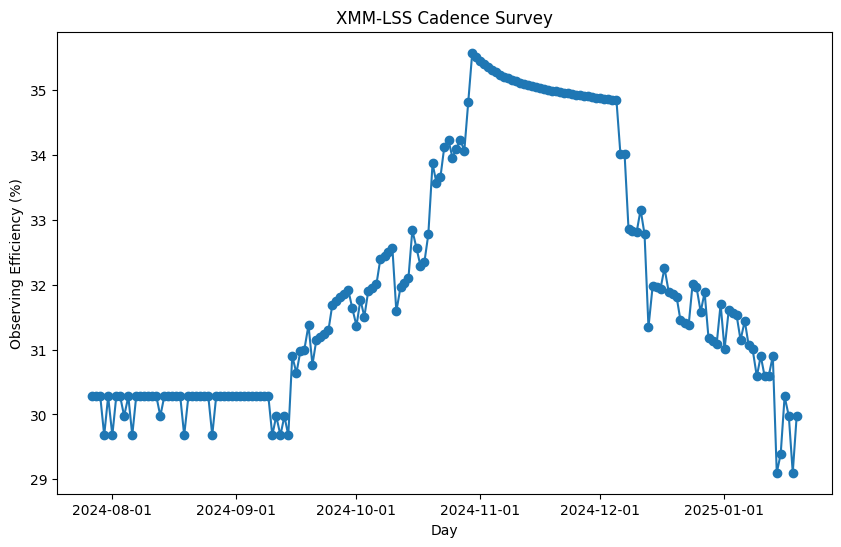

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv('cadence_result.csv')
# convert time from strings to datetime objects
df['Survey start time'] = pd.to_datetime(df['Survey start time'])

plt.figure(figsize=(10, 6))
plt.plot(df['Survey start time'], df['Observing efficiency (%)'], marker='o', linestyle='-')
plt.xlabel('Day')
plt.ylabel('Observing Efficiency (%)')
plt.title('XMM-LSS Cadence Survey')

# set the date format
date_format = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(date_format)

plt.show()


In [17]:
# obs_eff_list.append(obs_efficiency)
 #    time_elapsed_list.append(time_elapsed)
 #    survey_time_list.append(survey_time)
 #    other_survey_list.append(Other_Survey)
 #    exposure_list.append(Exposure)
 #    slew_list.append(Slew)
 #    settle_list.append(Settle)
 #    GSA_list.append(GS_Acquisition)
 #    dither_list.append(Dither)
 #    readout_list.append(Readout)
print(time_elapsed)
print(survey_time + Other_Survey)
print(Exposure+Slew+Settle+GS_Acquisition+Dither+Readout+Other_Survey)

24852.858745697413
24852.858745697413
24852.858745696998
